<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="700" height="200" />


### <font color='navy'> Modelos no lineales para pronósticos.

**Nombres:**
- Zamarrón Álvarez, Ana Rosaura
- Castillejos Jauregui, Claudia Celeste

**Fecha:** 24 de abril del 2023.

**Expediente** :
- 736222
- 735868

**Profesor:** Oscar David Jaramillo Zuluaga.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

2023-05-11 23:22:05.842958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Cargamos los datos
data = pd.read_csv("./traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


## EDA

In [4]:
# El tamaño del arreglo 
data.shape

(48120, 4)

In [5]:
#Ver el tipo de dato de las variables
data.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [6]:
# Cambiar el tipo de dato de las variables necesarias
data["ID"] = data["ID"].astype("object")
data["DateTime"] = pd.to_datetime(data['DateTime'])

In [7]:
# Ver el resultado del cambio en el tipo de variable 
data.dtypes

DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                  object
dtype: object

In [8]:
# Descripción de las variables numéricas
data.describe()

,Junction,Vehicles
count,48120.000000,48120.000000
mean,2.180549,22.791334
std,0.966955,20.750063
min,1.000000,1.000000
25%,1.000000,9.000000
50%,2.000000,15.000000
75%,3.000000,29.000000
max,4.000000,180.000000


In [9]:
# Vemos los valores de la columna date+time
data["DateTime"].value_counts()

2017-06-30 23:00:00    4
2017-03-02 02:00:00    4
2017-03-02 16:00:00    4
2017-03-02 15:00:00    4
2017-03-02 14:00:00    4
                      ..
2016-05-21 19:00:00    3
2016-05-21 20:00:00    3
2016-05-21 21:00:00    3
2016-05-21 22:00:00    3
2016-08-31 00:00:00    3
Name: DateTime, Length: 14592, dtype: int64

In [10]:
# Ver los registros con esa fecha
data[data["DateTime"] == "2017-06-30 23:00:00"]

,DateTime,Junction,Vehicles,ID
14591,2017-06-30 23:00:00,1,78,20170630231
29183,2017-06-30 23:00:00,2,27,20170630232
43775,2017-06-30 23:00:00,3,39,20170630233
48119,2017-06-30 23:00:00,4,12,20170630234


In [11]:
# Ver los registros con esa fecha
data[data["DateTime"] == "2017-03-02 02:00:00"]

,DateTime,Junction,Vehicles,ID
11690,2017-03-02 02:00:00,1,50,20170302021
26282,2017-03-02 02:00:00,2,24,20170302022
40874,2017-03-02 02:00:00,3,11,20170302023
45218,2017-03-02 02:00:00,4,5,20170302024


Las fechas se repiten para cada junction. Nos quedaremos con una sola serie , la de Junction 1.

In [12]:
# Reducimos la base de datos
junction1 = data[data["Junction"] == 1]
junction1.shape

(14592, 4)

In [13]:
#Hacemos una reducción de la base de datos
timeseries = junction1[["DateTime", "Vehicles"]].set_index('DateTime')
timeseries.head()

,Vehicles
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9


Text(0.5, 1.0, 'Junction 1 Vehicles Timeserie')

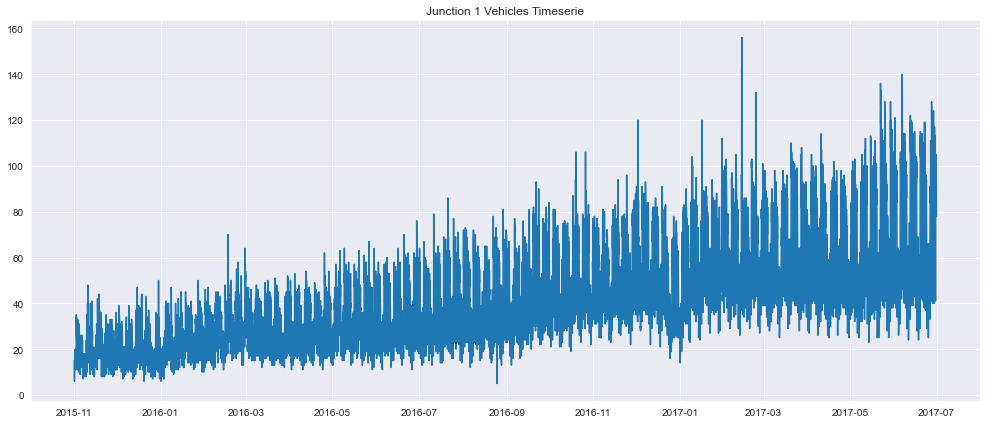

In [14]:
# Graficamos la serie de tiempo 
plt.figure(figsize=(17,7))
plt.plot(timeseries)
plt.title("Junction 1 Vehicles Timeserie")

array([[<AxesSubplot:title={'center':'Vehicles'}>]], dtype=object)

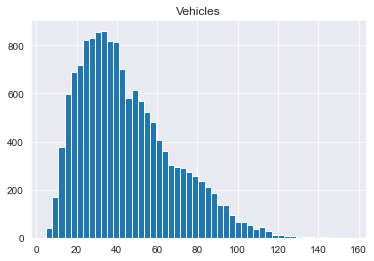

In [15]:
# Histogramas
timeseries.hist(bins=50)

<AxesSubplot:>

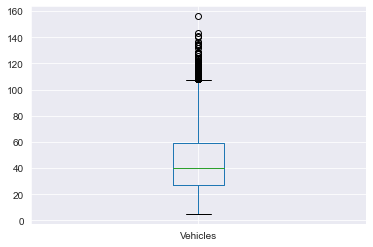

In [16]:
# Distribución de las varibales numéricas
timeseries.boxplot()

Tenemos varios outliers pero no consideramos que haga falta eliminarlas o tratarlas.

In [17]:
# Descripción de las variables numéricas
timeseries.describe()

,Vehicles
count,14592.000000
mean,45.052906
std,23.008345
min,5.000000
25%,27.000000
50%,40.000000
75%,59.000000
max,156.000000


## Modelos lineales

## Modelos no lineales
Se crearan diferentes modelos no lineales:
- MLP
- CNN
- LSTM Vanilla
- LSTM Stacked
- LSTM Bidirectional
- CNN-LSTM
- ConvLSTM

#### MLP

In [17]:
from sklearn.preprocessing import power_transform
from statsmodels.stats.diagnostic import kstest_normal

significance: 0.0010


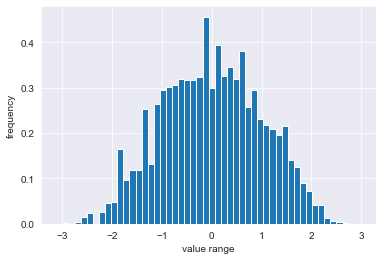

In [18]:
vals_bc = power_transform(timeseries, method='box-cox')

_, p = kstest_normal(vals_bc.squeeze())
print(f"significance: {p:.4f}")
plt.hist(vals_bc, bins=50, density=True)
plt.ylabel("frequency")
plt.xlabel("value range");

In [19]:
# dividir una secuencia univariada en muestras
def split_univariate_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps

        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence)-1:
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

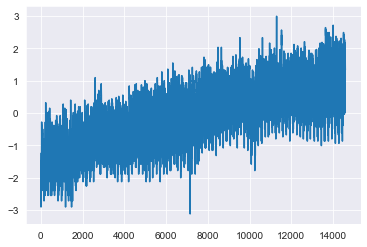

In [20]:
plt.plot(vals_bc)

In [21]:
# Elegir un número de pasos de tiempo
n_steps = 3
# Dividir en muestras
X, y = split_univariate_sequence(vals_bc, n_steps)

print('X', X, 'y', y, sep='\n')

X
[[[-1.67867827]
  [-1.88844909]
  [-2.25500586]]

 [[-1.88844909]
  [-2.25500586]
  [-2.71806446]]

 [[-2.25500586]
  [-2.71806446]
  [-2.39589795]]

 ...

 [[ 1.77549711]
  [ 2.00961311]
  [ 1.79973176]]

 [[ 2.00961311]
  [ 1.79973176]
  [ 1.65131936]]

 [[ 1.79973176]
  [ 1.65131936]
  [ 1.49516005]]]
y
[[-2.71806446]
 [-2.39589795]
 [-2.9063654 ]
 ...
 [ 1.65131936]
 [ 1.49516005]
 [ 1.33024985]]


In [24]:
# Definimos el modelo
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [25]:
def split_dataset(X, y):
    """
    Función que se encarga de dividir la data ingresada en datos de entrenamiento, validación y prueba.
    :param data: Data con la información de la serie de tiempo a analizar.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y)
print("X_train shape:", X_train.shape, "\ny_train shape:",y_train.shape,"\nX_val shape: ", X_val.shape, "\ny_val shape:", y_val.shape, "\nX_test shape:",X_test.shape, "\ny_test shape:",y_test.shape)

X_train shape: (10503, 3, 1) 
y_train shape: (10503, 1) 
X_val shape:  (1168, 3, 1) 
y_val shape: (1168, 1) 
X_test shape: (2918, 3, 1) 
y_test shape: (2918, 1)


In [ ]:
def cnn(n_steps, X_train, y_train, X_val, y_val, X_test, y_test):
    model = keras.models.Sequential([
        keras.layers.Input(n_steps),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)
    ])

    # Compilar el modelo y definir métricas y funciones de pérdida
    model.compile(optimizer='adam', loss='mape', metrics="mse")

    # Resumir el modelo compilado
    model.summary()

    history1 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=False)

    # Analizar función de pérdida
    plt.plot(history1.history['loss'], 'r--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Analizar las métricas
    plt.plot(history1.history['mse'], 'r--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_mape_score, test_mse_score = model.evaluate(X_test, y_test)
    return test_mape_score, test_mse_score


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               1024      
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 44,289
Trainable params: 44,289
Non-trainable params: 0
_________________________________________________________________


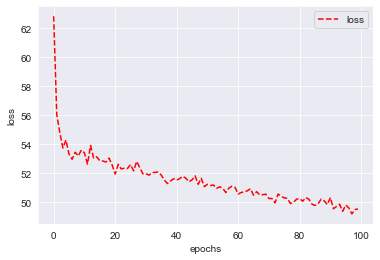

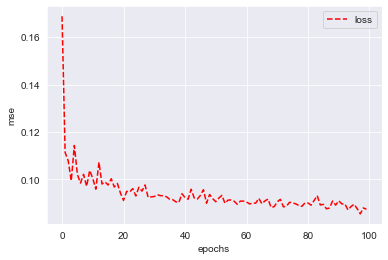

92/92 [==============================] - 0s 3ms/step - loss: 57.5414 - mse: 0.0902
MAPE en el conjunto de prueba: 57.5413932800293
MSE en el conjunto de prueba: 0.0901796966791153


In [41]:
test_mape_score, test_mse_score = cnn(n_steps, X_train, y_train, X_val, y_val, X_test, y_test)
print('MAPE en el conjunto de prueba:', test_mape_score)
print('MSE en el conjunto de prueba:', test_mse_score)

#### CNN

In [53]:
# Definir la secuencia de entrada
raw_seq = vals_bc.tolist()
# Elegir un número de pasos de tiempo
n_steps = 3
# Número de características de mis datos
n_features = 1
# Dividir en muestras
X, y = split_univariate_sequence(raw_seq, n_steps)

print('X', X, 'y', y, sep='\n')

X
[[[-1.67867827]
  [-1.88844909]
  [-2.25500586]]

 [[-1.88844909]
  [-2.25500586]
  [-2.71806446]]

 [[-2.25500586]
  [-2.71806446]
  [-2.39589795]]

 ...

 [[ 1.77549711]
  [ 2.00961311]
  [ 1.79973176]]

 [[ 2.00961311]
  [ 1.79973176]
  [ 1.65131936]]

 [[ 1.79973176]
  [ 1.65131936]
  [ 1.49516005]]]
y
[[-2.71806446]
 [-2.39589795]
 [-2.9063654 ]
 ...
 [ 1.65131936]
 [ 1.49516005]
 [ 1.33024985]]


In [29]:
def modelo_cnn(n_steps, X_train, y_train, X_val, y_val, X_test, y_test)
    # Definimos el modelo
    model_1 = Sequential()
    model_1.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps, n_features)))
    model_1.add(Dense(32, activation='relu'))
    model_1.add(MaxPooling1D())
    model_1.add(Flatten())
    model_1.add(Dense(1))

    model_1.summary()

    # Compilar el modelo y definir métricas y funciones de pérdida
    model_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mape', metrics=['mse'])

    h = model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=False)

    # Analizar función de pérdida
    plt.plot(h.history['loss'], 'r--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Analizar las métricas
    plt.plot(h.history['mse'], 'r--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_mape_score, test_mse_score = model_1.evaluate(X_test, y_test)
    return test_mape_score, test_mse_score

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 dense_5 (Dense)             (None, 2, 32)             2080      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
____________________________________________________

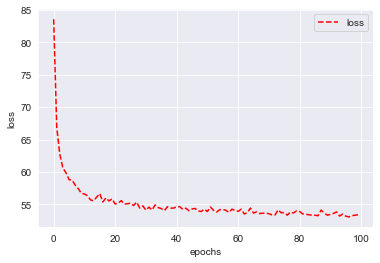

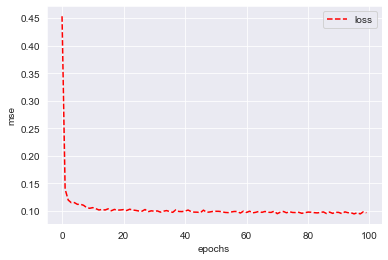

92/92 [==============================] - 0s 3ms/step - loss: 58.6882 - mse: 0.0954
MAPE en el conjunto de prueba: 58.68818664550781
MSE en el conjunto de prueba: 0.09535227715969086


In [30]:
cnn_test_mape_score1, cnn_test_mse_score1 = modelo_cnn(n_steps, X_train, y_train, X_val, y_val, X_test, y_test)
print('MAPE en el conjunto de prueba:', cnn_test_mape_score1)
print('MSE en el conjunto de prueba:', cnn_test_mse_score1)

#### LSTM

In [41]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Bidirectional

In [41]:
LSTM_earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=15)

In [36]:
def vanilla(n_steps, X_train, y_train, X_val, y_val, X_test, y_test):
    # Definimos el modelo
    rnn_model_1 = Sequential()
    rnn_model_1.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
    rnn_model_1.add(Dense(1))
    rnn_model_1.compile(optimizer='RMSprop', loss='mse')

    # plot_model(rnn_model_1, show_shapes=True)

    # Compilar el modelo y definir métricas y funciones de pérdida
    rnn_model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='mape', metrics=['mse'])

    h = rnn_model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[LSTM_earlystop], verbose=False)

    # Analizar función de pérdida
    plt.plot(h.history['loss'], 'b--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Analizar las métricas
    plt.plot(h.history['mse'], 'b--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_mape_score, test_mse_score = rnn_model_1.evaluate(X_test, y_test)
    return test_mape_score, test_mse_score

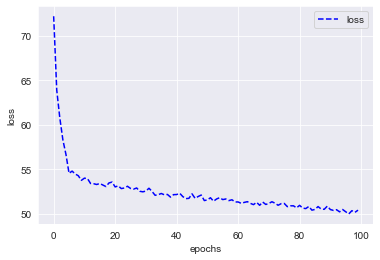

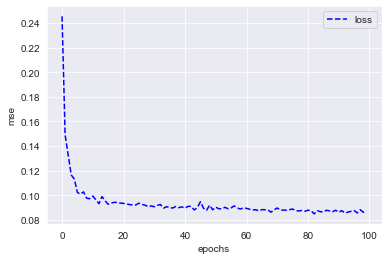

92/92 [==============================] - 0s 3ms/step - loss: 56.1820 - mse: 0.0912
MAPE en el conjunto de prueba: 56.18199920654297
MSE en el conjunto de prueba: 0.0912097841501236


In [37]:
vanilla_test_mape_score, vanilla_test_mse_score = vanilla(n_steps,X_train, y_train, X_val, y_val, X_test, y_test)
print('MAPE en el conjunto de prueba:', vanilla_test_mape_score)
print('MSE en el conjunto de prueba:', vanilla_test_mse_score)

#### Stacked

In [75]:
def stacked(n_steps, X_train, y_train, X_val, y_val, X_test, y_test):
    # Definimos el modelo
    rnn_model_2 = Sequential()
    rnn_model_2.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    rnn_model_2.add(LSTM(64, activation='relu'))
    rnn_model_2.add(Dense(1))
    rnn_model_2.compile(optimizer='RMSprop', loss='mse')

    rnn_model_2.summary()

    # Compilar el modelo y definir métricas y funciones de pérdida
    rnn_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='mape', metrics=['mse'])

    h = rnn_model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[LSTM_earlystop], verbose=False)

    # Analizar función de pérdida
    plt.plot(h.history['loss'], 'b--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Analizar las métricas
    plt.plot(h.history['mse'], 'b--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_mape_score, test_mse_score = rnn_model_2.evaluate(X_test, y_test)
    return test_mape_score, test_mse_score

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 3, 128)            66560     
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


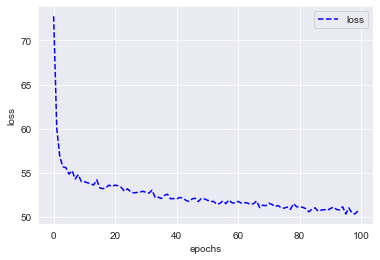

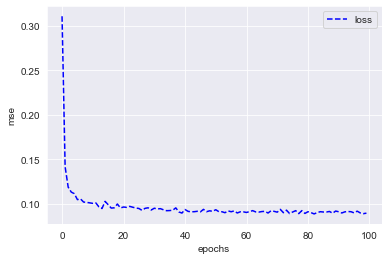

92/92 [==============================] - 1s 6ms/step - loss: 56.5633 - mse: 0.0790
MAPE en el conjunto de prueba: 56.56329345703125
MSE en el conjunto de prueba: 0.0789981558918953


In [76]:
stacked_test_mape_score, stacked_test_mse_score = stacked(n_steps,X_train, y_train, X_val, y_val, X_test, y_test)
print('MAPE en el conjunto de prueba:', stacked_test_mape_score)
print('MSE en el conjunto de prueba:', stacked_test_mse_score)

### Bidirectional

In [42]:
def bidirectional(n_steps, X_train, y_train, X_val, y_val, X_test, y_test):
    # Definimos el modelo
    rnn_model_3 = Sequential()
    rnn_model_3.add(Bidirectional(
        LSTM(100, activation='relu'),
        input_shape=(n_steps, n_features)
    ))
    rnn_model_3.add(Dense(1))
    rnn_model_3.compile(optimizer='RMSprop', loss='mse')

    rnn_model_3.summary()

    # Compilar el modelo y definir métricas y funciones de pérdida
    rnn_model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='mape', metrics=['mse'])

    h = rnn_model_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[LSTM_earlystop],
                        verbose=False)

    # Analizar función de pérdida
    plt.plot(h.history['loss'], 'b--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Analizar las métricas
    plt.plot(h.history['mse'], 'b--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_mape_score, test_mse_score = rnn_model_3.evaluate(X_test, y_test)
    return test_mape_score, test_mse_score

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              81600     
 l)                                                              
                                                                 
 dense_10 (Dense)            (None, 1)                 201       
                                                                 
Total params: 81,801
Trainable params: 81,801
Non-trainable params: 0
_________________________________________________________________


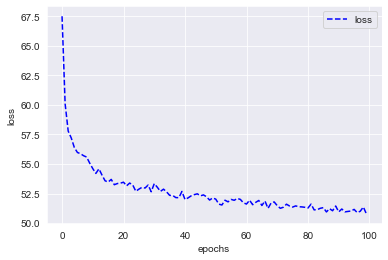

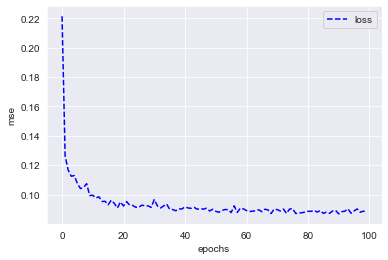

92/92 [==============================] - 0s 4ms/step - loss: 55.7356 - mse: 0.0801
MAPE en el conjunto de prueba: 55.735572814941406
MSE en el conjunto de prueba: 0.08010440319776535


In [43]:
bidirectional_test_mape_score, bidirectional_test_mse_score = bidirectional(n_steps, X_train, y_train, X_val, y_val, X_test, y_test)
print('MAPE en el conjunto de prueba:', bidirectional_test_mape_score)
print('MSE en el conjunto de prueba:', bidirectional_test_mse_score)

### CNN-LSTM

In [45]:
def modelo_cnn_lstm(n_steps, X_train, y_train, X_val, y_val, X_test, y_test):
    # Definimos el modelo
    cnn_rnn_model_2 = Sequential()
    cnn_rnn_model_2.add(Bidirectional(
        LSTM(64, activation='relu'),
        input_shape=(n_steps, n_features)
    ))
    cnn_rnn_model_2.add(Dense(64, activation='relu'))
    cnn_rnn_model_2.add(Dense(1))
    cnn_rnn_model_2.compile(optimizer='RMSprop', loss='mse')

    cnn_rnn_model_2.summary()

    # Compilar el modelo y definir métricas y funciones de pérdida
    cnn_rnn_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='mape', metrics=['mse'])

    h = cnn_rnn_model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[LSTM_earlystop],
                            verbose=False)

    # Analizar función de pérdida
    plt.plot(h.history['loss'], 'b--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Analizar las métricas
    plt.plot(h.history['mse'], 'b--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_mape_score, test_mse_score = cnn_rnn_model_2.evaluate(X_test, y_test)
    return test_mape_score, test_mse_score

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 128)              33792     
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 42,113
Trainable params: 42,113
Non-trainable params: 0
_________________________________________________________________


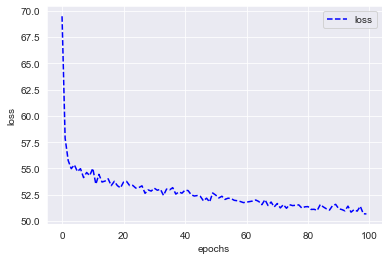

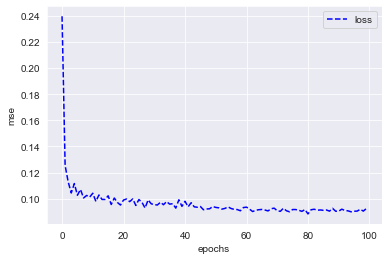

92/92 [==============================] - 0s 2ms/step - loss: 56.3501 - mse: 0.0829
MAPE en el conjunto de prueba: 56.35009002685547
MSE en el conjunto de prueba: 0.08293233066797256


In [46]:
cnn_lstm_test_mape_score, cnn_lstm_test_mse_score = modelo_cnn_lstm(n_steps, X_train, y_train, X_val, y_val, X_test, y_test)
print('MAPE en el conjunto de prueba:', cnn_lstm_test_mape_score)
print('MSE en el conjunto de prueba:', cnn_lstm_test_mse_score)

### ConvLSTM

In [32]:
from keras.layers import ConvLSTM2D

In [47]:
# dividir una secuencia univariada en muestras
def split_univariate_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps

        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence)-1:
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [48]:
raw_seq = vals_bc.tolist()
# Elegir un número de pasos de tiempo
n_steps = 4
# Dividir en muestras
X2, y2 = split_univariate_sequence(raw_seq, n_steps)
print(f'Shape función split {X.shape}')
# reshape de [samples, timesteps] a [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X2 = X2.reshape((X2.shape[0], n_seq, 1, n_steps, n_features))
print(f'Shape después de la transformación  {X2.shape}')

Shape función split (14589, 3, 1)
Shape después de la transformación  (14588, 2, 1, 2, 1)


In [37]:
LSTM_earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=10)

In [27]:
def modelo_conv_lstm(n_steps, X_train, y_train, X_val, y_val, X_test, y_test):
    # Definimos el modelo
    cnn_rnn_model_2 = Sequential()
    cnn_rnn_model_2.add(
    ConvLSTM2D(
        filters=64,
        # kernel_size en términos de (row, columns)
        kernel_size=(1, n_steps),
        activation='relu',
        input_shape=(n_seq, 1, n_steps, n_features)
    )
)
    cnn_rnn_model_2.add(Flatten())
    cnn_rnn_model_2.add(Dense(1))
    cnn_rnn_model_2.compile(optimizer='adam', loss='mse')
    cnn_rnn_model_2.summary()

    # Compilar el modelo y definir métricas y funciones de pérdida
    cnn_rnn_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='mape', metrics=['mse'])

    h = cnn_rnn_model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[LSTM_earlystop],
                            verbose=False)

    # Analizar función de pérdida
    plt.plot(h.history['loss'], 'b--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # Analizar las métricas
    plt.plot(h.history['mse'], 'b--', label='loss')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_mape_score, test_mse_score = cnn_rnn_model_2.evaluate(X_test, y_test)
    return test_mape_score, test_mse_score

In [49]:
# Train val test split
X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X2, y2)
print("X_train shape:", X_train.shape, "\ny_train shape:",y_train.shape,"\nX_val shape: ", X_val.shape, "\ny_val shape:", y_val.shape, "\nX_test shape:",X_test.shape, "\ny_test shape:",y_test.shape)

X_train shape: (10503, 2, 1, 2, 1) 
y_train shape: (10503, 1) 
X_val shape:  (1167, 2, 1, 2, 1) 
y_val shape: (1167, 1) 
X_test shape: (2918, 2, 1, 2, 1) 
y_test shape: (2918, 1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 1, 64)          33536     
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


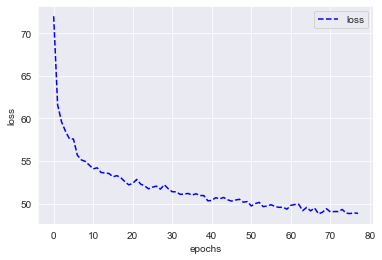

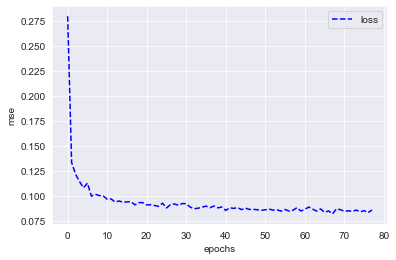

92/92 [==============================] - 0s 4ms/step - loss: 53.0683 - mse: 0.0865
MAPE en el conjunto de prueba: 53.06827163696289
MSE en el conjunto de prueba: 0.08649331331253052


In [38]:
conv_lstm_test_mape_score, conv_lstm_test_mse_score = modelo_conv_lstm(n_steps, X_train, y_train, X_val, y_val, X_test, y_test)
print('MAPE en el conjunto de prueba:', conv_lstm_test_mape_score)
print('MSE en el conjunto de prueba:', conv_lstm_test_mse_score)

### Comparación

In [42]:
cm = pd.DataFrame([0.0829, 0.09535, 0.091209, 0.082645, 0.08010, 0.082932, 0.0864933], columns=["MSE metric"])
cm.index = ["MLP", "CNN", "LSTM", "Stacked", "Bidirectional", "CNN-LSTM", "ConvLSTM"]
cm = cm.sort_values("MSE metric", ascending=True)
cm

,MSE metric
Bidirectional,0.080100
Stacked,0.082645
MLP,0.082900
CNN-LSTM,0.082932
ConvLSTM,0.086493
LSTM,0.091209
CNN,0.095350


<AxesSubplot:>

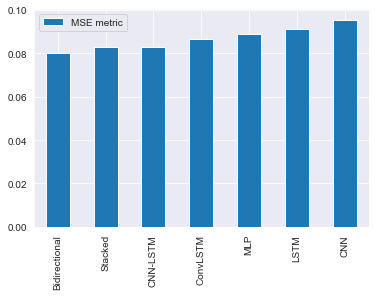

In [48]:
cm.plot(kind="bar")

### Optuna Bidirectional

In [27]:
import optuna
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense

In [28]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((10503, 3, 1), (10503, 1), (1168, 3, 1), (1168, 1), (2918, 3, 1), (2918, 1))

In [35]:
def objective(trial):
    # Definir los hiperparámetros a ajustar
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 20, 150)


   # Definir el modelo
    rnn_model = Sequential()
    rnn_model.add(Bidirectional(
        LSTM(lstm_units, activation='relu'),
        input_shape=(n_steps, n_features)
    ))
    rnn_model.add(Dense(1))
    rnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mape')

    # Compilar el modelo con los hiperparámetros ajustados
    rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse')

    # Entrenar el modelo y obtener el error de validación
    history = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size=batch_size, verbose=0)
    val_loss = history.history['val_loss'][-1]

    return val_loss

In [36]:
# Definir los parámetros de la red neuronal
n_steps = 3
n_features = 1

# Definir el objeto de estudio de Optuna y ejecutar la búsqueda de hiperparámetros
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Imprimir los resultados
print('Best trial:', study.best_trial.params)
print('Best validation loss:', study.best_trial.value)

[I 2023-05-11 19:33:27,309] A new study created in memory with name: no-name-6bfe7469-0ded-4521-ace8-f2de30388680
/var/folders/vy/11j1fpvs73d2q6m6tfbtxl4c0000gn/T/ipykernel_18966/845220991.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2023-05-11 19:35:58,915] Trial 0 finished with value: 0.06806692481040955 and parameters: {'learning_rate': 0.00013365524685134714, 'lstm_units': 32, 'batch_size': 32, 'num_epochs': 118}. Best is trial 0 with value: 0.06806692481040955.
[I 2023-05-11 19:37:06,768] Trial 1 finished with value: 0.06663716584444046 and parameters: {'learning_rate': 0.0008023707605045042, 'lstm_units': 64, 'batch_size': 128, 'num_epochs': 117}. Best is trial 1 with value: 0.06663716584444046.
[I 2023-05-11 19:37:56,891] Trial 2

Best trial: {'learning_rate': 0.022525727073559966, 'lstm_units': 64, 'batch_size': 32, 'num_epochs': 114}
Best validation loss: 0.06537339091300964


In [39]:
# Obtener los mejores hiperparámetros y el F1-Score correspondiente
best_params = study.best_params
best_score = study.best_value
print("best params: ", best_params, "\n best score:", best_score)

best params:  {'learning_rate': 0.022525727073559966, 'lstm_units': 64, 'batch_size': 32, 'num_epochs': 114} 
 best score: 0.06537339091300964


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirecti  (None, 128)              33792     
 onal)                                                           
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________


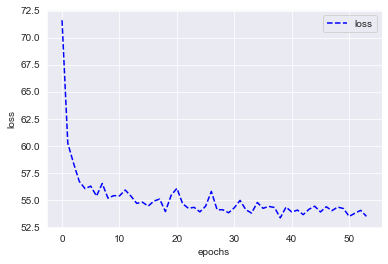

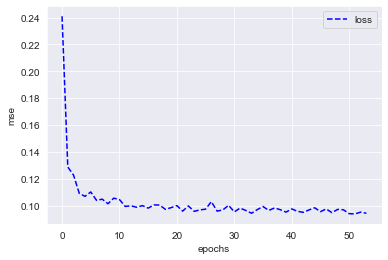

92/92 [==============================] - 0s 4ms/step - loss: 56.8080 - mse: 0.0889


In [43]:
# Definimos el modelo
rnn_model_3 = Sequential()
rnn_model_3.add(Bidirectional(
    LSTM(64, activation='relu'),
    input_shape=(n_steps, n_features)
))
rnn_model_3.add(Dense(1))
rnn_model_3.compile(optimizer='RMSprop', loss='mse')

rnn_model_3.summary()

# Compilar el modelo y definir métricas y funciones de pérdida
rnn_model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.022525727073559966), loss='mape', metrics=['mse'])

h = rnn_model_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=114, batch_size=32, callbacks=[LSTM_earlystop],
                    verbose=False)

# Analizar función de pérdida
plt.plot(h.history['loss'], 'b--', label='loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Analizar las métricas
plt.plot(h.history['mse'], 'b--', label='loss')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

# Evaluar el modelo en el conjunto de prueba
test_mape_score, test_mse_score = rnn_model_3.evaluate(X_test, y_test)

Obtuvimos un mse de 0.0889 con los hiperparámetros óptimos.

## Clasificación

In [21]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [78]:
df = data.set_index("DateTime")
df.drop("ID", axis=1, inplace=True)
df.head()

,Junction,Vehicles
DateTime,,
2015-11-01 00:00:00,1,15
2015-11-01 01:00:00,1,13
2015-11-01 02:00:00,1,10
2015-11-01 03:00:00,1,7
2015-11-01 04:00:00,1,9


In [79]:
df.Junction.unique()

array([1, 2, 3, 4])

In [80]:
def split_dataset(X, y):
    """
    Función que se encarga de dividir la data ingresada en datos de entrenamiento y prueba.
    :param data: Data con la información de la serie de tiempo a analizar.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    return X_train, y_train, X_test, y_test

In [81]:
X = df["Vehicles"]
y = df["Junction"]

In [82]:
# Verificamos que no hayan valores nulos
X.isna().sum()

0

In [83]:
X_train, y_train, X_test, y_test = split_dataset(X, y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38496,), (38496,), (9624,), (9624,))

In [84]:
X_train.head()

DateTime
2015-12-15 16:00:00     5
2015-12-05 18:00:00     1
2016-04-13 14:00:00    18
2016-11-28 11:00:00    21
2016-01-26 02:00:00    12
Name: Vehicles, dtype: int64

In [85]:
# resumir el balance de clases en una columna variable de salida usando DataFrame.value_counts()
def class_breakdown(data):
    df = pd.DataFrame(data)
    vc = df.value_counts() #/ len(data) * 100
    vc = vc.to_frame()
    vc.index.name = 'Class'
    vc.columns = ['n']
    vc['count'] = vc['n'].round(2)
    print('balance de clases', vc, sep='\n')
    # Graficar el balance de clases
    vc['count'].plot(kind='bar')
    plt.show()

train Data
balance de clases
              n  count
Junction              
3         11710  11710
1         11664  11664
2         11655  11655
4          3467   3467


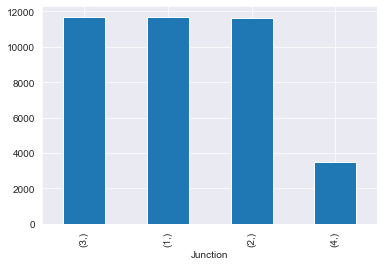

test Data
balance de clases
             n  count
Junction             
2         2937   2937
1         2928   2928
3         2882   2882
4          877    877


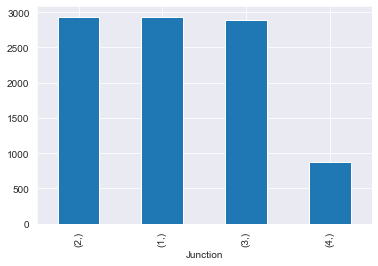

In [86]:
print('train Data')
class_breakdown(y_train)

print('test Data')
class_breakdown(y_test)

### Balanceo de clases

In [87]:
from imblearn.under_sampling import RandomUnderSampler

In [88]:
X_train.shape, y_train.shape

((38496,), (38496,))

In [89]:
y_train.unique()

array([3, 2, 1, 4])

Text(0.5, 1.0, 'Cuenta de la variable de salida')

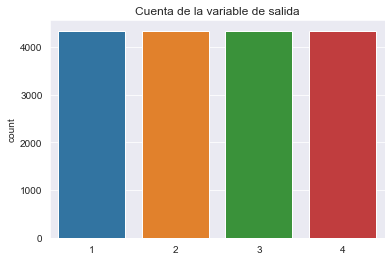

In [90]:
#Balancear datos de salida usando algoritmo de SMOTE
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(np.array(X).reshape(-1, 1), np.array(y))

sns.countplot(x=y_train_resampled).set_title("Cuenta de la variable de salida")

In [91]:
# Obtener los valores únicos y sus frecuencias
valores_unicos, frecuencias = np.unique(y_train_resampled, return_counts=True)
valores_unicos, frecuencias

(array([1, 2, 3, 4]), array([4344, 4344, 4344, 4344]))

In [92]:
# Normalizamos los datos con MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_resampled)
X_train_normalized = scaler.transform(X_train_resampled)
X_test_normalized = scaler.transform(np.array(X_test).reshape(-1,1))

In [70]:
X_train_normalized.shape, X_test_normalized.shape

((17376, 1), (9624, 1))

In [71]:
X_train_normalized[:10]

array([[ 1.22642849],
       [ 2.81022348],
       [ 0.20462527],
       [ 1.37969897],
       [ 1.78842026],
       [ 0.51116623],
       [ 0.51116623],
       [ 0.86879736],
       [ 0.71552688],
       [-0.45954682]])

### Machine Learning

Haremos modelos de KNeighborsClassifier, Bayes, Support Vector Classifier, Decision Tree Classifier, Random Forest Classifier, Extra Trees Classifier.

In [37]:
# crear un dict de modelos estándar para evaluar {nombre:objeto}
def define_models(models=dict()):
    # nonlinear models
    models['knn'] = KNeighborsClassifier(n_neighbors=7)
    models["bayes"] = GaussianNB()
    models['svm'] = SVC()
    models['dt'] = DecisionTreeClassifier()

    # ensemble models
    models['rf'] = RandomForestClassifier(n_estimators=100)
    models['et'] = ExtraTreesClassifier(n_estimators=100)
    print('Defined %d models' % len(models))
    return models

In [38]:
# evaluar un solo modelo
def evaluate_model(X_train, y_train, X_test, y_test, model):
    # Ajustar el modelo
    model.fit(X_train, y_train)
    # Realizar predicciones
    yhat = model.predict(X_test)
    # Evaluar predicciones
    accuracy = accuracy_score(y_test, yhat)
    return accuracy * 100.0

In [39]:
# Evaluar diccionario de modelos {name:object}, regresa {name:score}
def evaluate_models(X_train, y_train, X_test, y_test, models):
    results = dict()
    for name, model in models.items():
        # Evaluar el modelo
        results[name] = evaluate_model(X_train, y_train, X_test, y_test, model)
        # Mostrar el proceso
        print('>%s: %.3f' % (name, results[name]))
    return results

In [40]:
# Imprimir y mostrar los resultados
def summarize_results(results, maximize=True):
    # Crear lista de (name, mean(scores)) tuplas
    mean_scores = [(k,v) for k,v in results.items()]
    # Ordenar tuplas por score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse para orden descendiente (ej. para accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    print()
    for name, score in mean_scores:
        print('Name=%s, Score=%.3f' % (name, score))

In [41]:
X_train_normalized.shape, y_train_resampled.shape, X_test_normalized.shape, y_test.shape

((17376, 1), (17376,), (9624, 1), (9624,))

In [42]:
# Generar el diccionario de modelos
models = define_models()

# Evaluar los modelos
results = evaluate_models(X_train_normalized, y_train_resampled , X_test_normalized, y_test, models)

# Resumir los resultados de los modelos
summarize_results(results)

Defined 6 models
>knn: 34.840
>bayes: 46.166
>svm: 48.919
>dt: 50.634
>rf: 49.210
>et: 50.634

Name=et, Score=50.634
Name=dt, Score=50.634
Name=rf, Score=49.210
Name=svm, Score=48.919
Name=bayes, Score=46.166
Name=knn, Score=34.840


### Optuna

In [ ]:
from keras.utils import to_categorical

In [96]:
# one hot encode y
y_train_resampled = to_categorical(y_train_resampled)
# Eliminar la primera columna
y_train_resampled = y_train_resampled[:, 1:]
y_train_resampled

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [98]:
# one hot encode y
y_test = to_categorical(y_test)
# Eliminar la primera columna
y_test = y_test[:, 1:]
y_test

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

In [111]:
X_train_normalized.shape, y_train_resampled.shape, X_test.shape, y_test.shape

((17376, 1), (17376, 4), (9624, 1, 1), (9624, 4))

In [140]:
import optuna
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [142]:
def objective(trial):
    # Definir los posibles rangos de valores para los hiperparámetros que se quieren probar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, log=True),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 5, 50, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'class_weight': 'balanced',
        'n_jobs': -1
    }

    # Crear el modelo ExtraTreesClassifier con los hiperparámetros sugeridos por Optuna
    etc = ExtraTreesClassifier(random_state=42, **params)

    # Calcular el F1-Score utilizando la validación cruzada con 5 particiones
    f1_scores = cross_val_score(etc, X_train_normalized, y_train_resampled, cv=5, scoring='f1_micro')

    # Devolver el valor medio del F1-Score como objetivo a optimizar
    return np.mean(f1_scores)


# Crear un objeto Optuna Study y optimizar el modelo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2023-05-12 00:44:28,972] A new study created in memory with name: no-name-2da4fb7f-3aaf-4fff-9e46-6e56ce63885a
[I 2023-05-12 00:44:34,375] Trial 0 finished with value: 0.4315453829413135 and parameters: {'n_estimators': 68, 'criterion': 'gini', 'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.4315453829413135.
[I 2023-05-12 00:44:39,352] Trial 1 finished with value: 0.4071396396072239 and parameters: {'n_estimators': 66, 'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4315453829413135.
[I 2023-05-12 00:45:00,916] Trial 2 finished with value: 0.4101134747390677 and parameters: {'n_estimators': 367, 'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4315453829413135.
[I 2023-05-12 00:45:11,964] Trial 3 finished with value: 0.4070012207509694 and parameters: {'n_estimators': 331, 'criterion': 'entropy', 

In [144]:
# Obtener los mejores hiperparámetros y el F1-Score correspondiente
best_params = study.best_params
best_score = study.best_value
best_params, best_score

({'n_estimators': 197,
  'criterion': 'entropy',
  'max_depth': 45,
  'min_samples_split': 5,
  'min_samples_leaf': 1},
 0.47613110832548494)

In [145]:
# Crear el modelo ExtraTreesClassifier con los mejores hiperparámetros y ajustarlo a los datos
best_etc = ExtraTreesClassifier(random_state=42, **best_params)
best_etc.fit(X_train_normalized, y_train_resampled)

ExtraTreesClassifier(criterion='entropy', max_depth=45, min_samples_split=5,
                     n_estimators=197, random_state=42)

In [146]:
# Hacer predicciones en los datos de prueba (reemplazar con tus propios datos) y calcular el F1-Score
y_pred = best_etc.predict(X_test_normalized)
f1 = f1_score(y_test, y_pred, average="micro")
f1

0.38673483880130666